<a href="https://colab.research.google.com/github/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [169]:
!mkdir working
%cd working


/content/working/working/working/working


In [170]:
%pwd

'/content/working/working/working/working'

In [171]:
#!wget https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/tree/main/datasets/movies.csv datasets
!git clone https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari.git 

Cloning into 'arge-odakli-yapay-zeka-egitimi2-sorulari'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 50 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [172]:
#!wget https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/tree/main/datasets/ratings.csv

In [173]:
#!wget https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/tree/main/datasets/README.txt

# **Load Library**

In [174]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
from PIL import Image
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer



In [175]:
!pip install -q nltk

In [176]:
import nltk # Natural Language Tool Kit 
from nltk.corpus import stopwords # Stopwords corpus is a list of commonly used words in a language

In [177]:
os.listdir("./arge-odakli-yapay-zeka-egitimi2-sorulari/datasets/")

['README.txt', 'movies.csv', 'ratings.csv']

In [178]:
!cat ./arge-odakli-yapay-zeka-egitimi2-sorulari/README.md

# Araştırma ve Geliştirme Odaklı Yapay Zeka Eğitimi Soruları


Başvuru kabulü için size sorulan soruyu çözmenizden çok, o soruyu çözmek için ne kadar uğraştığınız önemlidir. Motivasyonu yüksek gençlerle çalışmak çok farklı, bunu biliyoruz, sizi önemsiyoruz ve bekliyoruz.
 
## Soru - Film Önerme
MovieLens verisetini kullanarak kişilere film önerisi yapan bir fonksiyon geliştirmeniz beklenmektedir. Aşağıdaki notebook'u temel alarak çalışmanızı yapabilirsiniz. 

- [Film Önerme](https://github.com/kaveai/arge-odakli-yapay-zeka-egitimi2-sorulari/blob/main/Soru1.ipynb)


## Data Story

In [179]:
!cat ./arge-odakli-yapay-zeka-egitimi2-sorulari/datasets/README.txt

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

## Load & Check Datasets

In [180]:
dataset_dir="./arge-odakli-yapay-zeka-egitimi2-sorulari/datasets/"

In [181]:
movies = pd.read_csv(dataset_dir+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [182]:
ratings = pd.read_csv(dataset_dir+'ratings.csv',parse_dates=["timestamp"])
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [183]:
print("Movie Shape: " ,movies.shape )
print("Ratings Shape: " ,ratings.shape )

print("-"*30)

print("Any null values in Movie:" ,movies.isnull().values.any())
print("Any null values in Ratings: ",ratings.isnull().values.any())

print("-"*30)

print("How many null values in Which Movie's feature:\n" ,movies.isnull().sum())
print("-"*30)
print("How many null values in Which Ratings's feature:\n ",ratings.isnull().sum())


Movie Shape:  (9742, 3)
Ratings Shape:  (100836, 4)
------------------------------
Any null values in Movie: False
Any null values in Ratings:  False
------------------------------
How many null values in Which Movie's feature:
 movieId    0
title      0
genres     0
dtype: int64
------------------------------
How many null values in Which Ratings's feature:
  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Concanate Datasets

In [184]:
# MovieID üzerinden kişilerin yorumlarına film isimlerini ve genrelerini ekliyoruz. 
df = pd.merge(ratings, movies, how='left', on='movieId')

df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


**Yukarıdan da görebileceğiniz gibi, userId ve movieId, her kullanıcıyı ve filmi ayırt etmek için iki önemli sütundur. Derecelendirme olan aşağıdaki sütun için, bir veya daha fazla film için her kullanıcının derecelendirmesidir. Aşağıdaki sütun zaman damgası, UNIX tarih formatı açısından tarihi temsil eder. Ve son iki sütun, her filmin başlığını ve türünü temsil eder.**

In [185]:
# Number of Users who rated at least one movie:
print("Number of Users who rated at least one move: ", rating_movie.userId.nunique())
print("-"*30)

# Number of Movies in the dataset:
print("Number of Movies in the dataset:", rating_movie.title.nunique())
print("-"*30)

# Unique of Rating points in the dataset:
# Unique of Rating points in the dataset:
print("Unique Rating points:", rating_movie.rating.unique())

Number of Users who rated at least one move:  610
------------------------------
Number of Movies in the dataset: 9719
------------------------------
Unique Rating points: [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


In [186]:
# Extracting movie release years into one column
rating_movie['movie_year'] = rating_movie.title.str.extract('.*\((.*)\).*') # extract() method is used to extract the string from the given string  .*\((.*)\).* means the string which is not a word or digit and (.*) means the string which is not a word or digit and (\) means the string which is not a word or digit
rating_movie.head()

,userId,movieId,rating,timestamp,title,genres,movie_year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [205]:
# Removing year from the movie title
rating_movie['title'] = rating_movie.title.str.replace('(\(\d\d\d\d\))', '') # replace() method is used to replace the string with another string

rating_movie.head()

,userId,movieId,rating,timestamp,title,genres,movie_year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,964981247,Grumpier Old Men,Comedy|Romance,1995
2,1,6,4.0,964982224,Heat,Action|Crime|Thriller,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en),Mystery|Thriller,1995
4,1,50,5.0,964982931,"Usual Suspects, The",Crime|Mystery|Thriller,1995


In [207]:
# convert timestamp to datetime
rating_movie['timestamp'] = pd.to_datetime(rating_movie['timestamp'], unit='s')
rating_movie.head()

,userId,movieId,rating,timestamp,title,genres,movie_year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995
2,1,6,4.0,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995


In [208]:
# s,plitting genres into list of genres
rating_movie['genres'] = rating_movie.genres.str.split('|')
rating_movie

,userId,movieId,rating,timestamp,title,genres,movie_year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,2000-07-30 18:37:04,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995
...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,Split,"[Drama, Horror, Thriller]",2017
100832,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017
100833,610,168250,5.0,2017-05-08 19:50:47,Get Out,[Horror],2017
100834,610,168252,5.0,2017-05-03 21:19:12,Logan,"[Action, Sci-Fi]",2017


In [209]:
# fro faster processing of large size data 
# we save it as a parquet file or pickle file
# but parquet  takes up less space 
rating_movie.to_parquet("ratesmovies.parquet",compression="gzip") 
rating_movie.to_pickle("ratesmovies.pickle")

In [210]:
data=pd.read_parquet("ratesmovies.parquet")

**Yukarıda keşfettiğimiz gibi, tam sayı olmayan bazı derecelendirmeler vardır. Benzersiz derecelendirme noktalarının sayısını daraltmak için tavan işlevini kullanacağım ve yalnızca 1 ile 5 arasında derecelendirmeler elde edeceğim.**

In [189]:
# Removing decimal values to the ceiling value to decrease number of rating classes
data.rating = np.ceil(data.rating)
print("Unique Rating Points:", data.rating.unique())

Unique Rating Points: [4. 5. 3. 2. 1.]


## Exploratary Data analysis

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   timestamp   100836 non-null  object 
 4   title       100836 non-null  object 
 5   genres      100836 non-null  object 
 6   movie_year  100819 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.2+ MB


In [211]:
data.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [216]:
import plotly.express as px # import plotly express module for visualization of data 
_ = data.title.value_counts()
fig = px.histogram(_, x=_, opacity=0.85, marginal='violin', title='Movie Rating Distribution',
                   labels={
                       'x': 'Number of Ratings taken'})
fig.update_traces(marker=dict(line=dict(color='#050000', width=1)))
fig.update_layout(title_text='Distribution of the Number of Ratings taken by the Movies',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

**Yukarıdaki şekle göre, filmlerin çoğu yalnızca bir kullanıcı tarafından derecelendirilmiştir (3272 film). Bu filmler, bir film öneri motoru oluşturmamıza yardımcı olmaz çünkü işbirlikçi bir filtreleme tabanlı öneri motoru oluşturacağız. Bu nedenle, 10'dan az kullanıcı puanı alan filmleri bırakacağım.**

In [193]:
data['movieId'].value_counts()[data["movieId"].value_counts()>=10].index

Int64Index([  356,   318,   296,   593,  2571,   260,   480,   110,   589,
              527,
            ...
              728,  8947,  7137, 79057,  2142,  1096,  1541,  4103,   818,
             2111],
           dtype='int64', length=2269)

In [194]:
# Removing movies that rated less than 10
movieFrequency_greater_10 = data['movieId'].value_counts()[data['movieId'].value_counts() >= 10].index
data = data[data.movieId.isin(movieFrequency_greater_10)]

print("Minimum Number of Rated Movies after Drop:", data.title.value_counts().nsmallest(5))   # So we achieved to obtain number of ratings taken by users minimum 10

Minimum Number of Rated Movies after Drop: Swimming with Sharks (1995)    10
Get Him to the Greek (2010)    10
Beautiful Girls (1996)         10
Hunt, The (Jagten) (2012)      10
Moana (2016)                   10
Name: title, dtype: int64


In [195]:
rating_movie.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

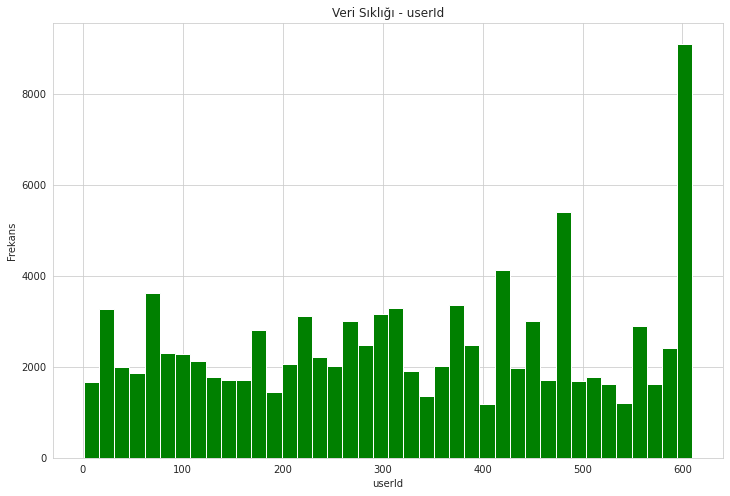

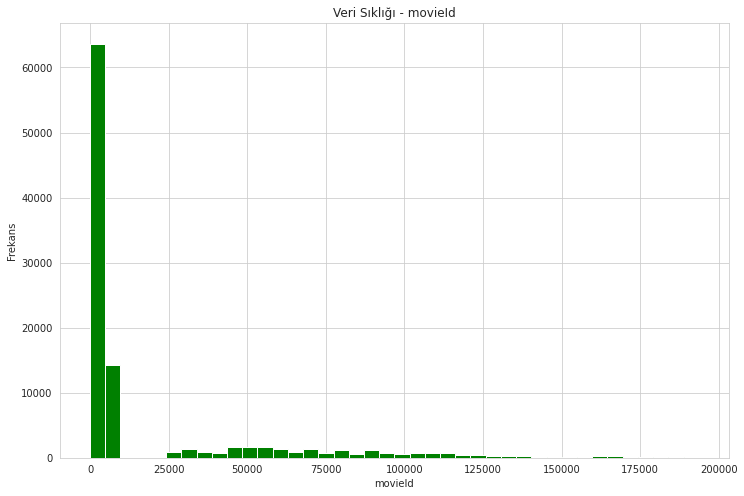

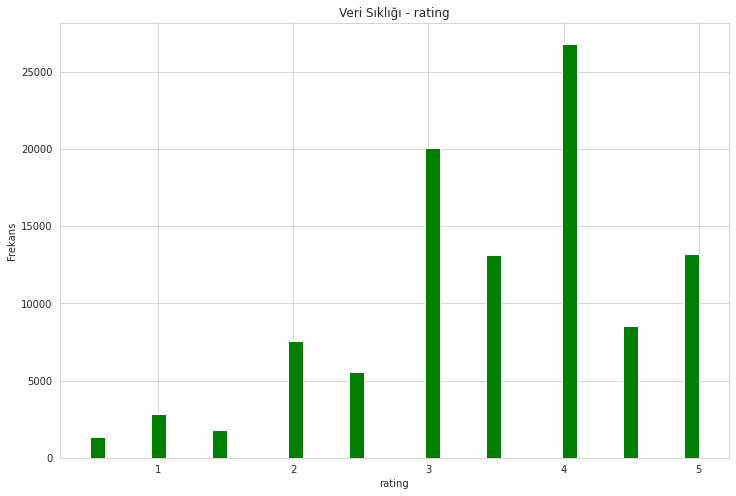

In [217]:
def plotHistogram(degisken):
    plt.figure(figsize=(12,8))
    plt.hist(rating_movie[degisken],bins=40,color="green",density=False)
    plt.xlabel(degisken)
    plt.ylabel("Frekans")
    plt.title("Veri Sıklığı - {}".format(degisken))
    plt.show()

sayisal_degisken=rating_movie.select_dtypes([np.number]).columns
for i in sayisal_degisken:
    plotHistogram(i)

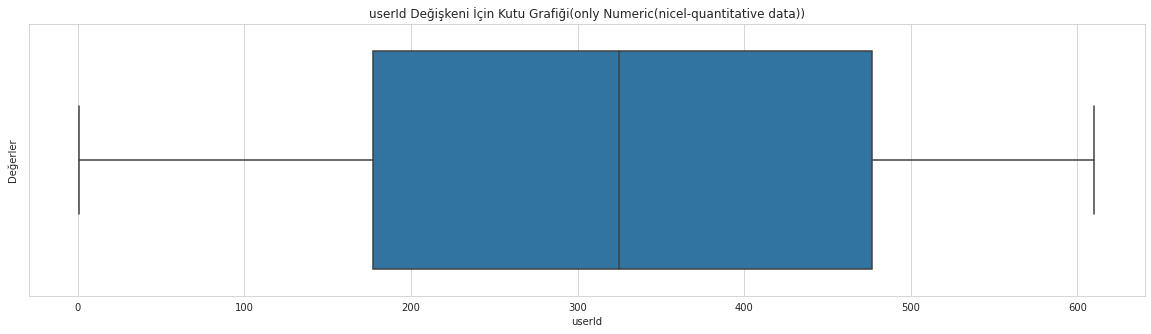

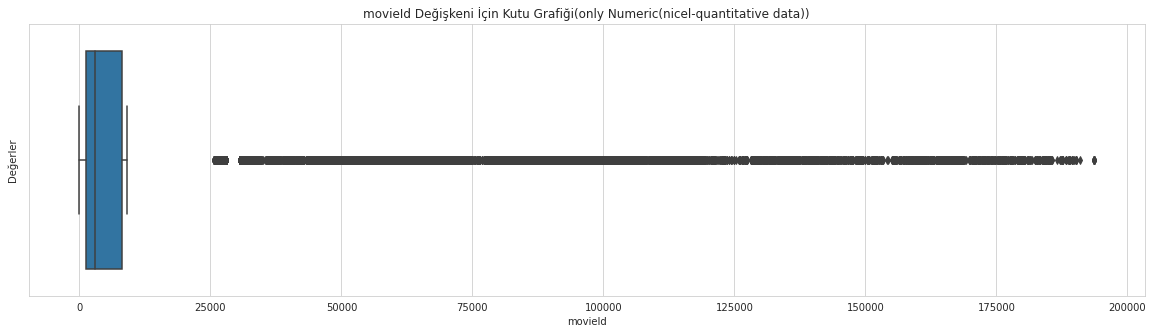

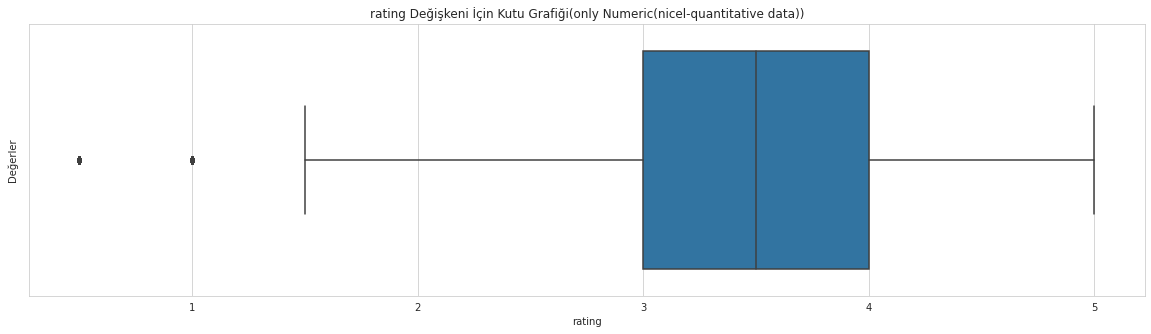

In [197]:
def plotbox(numericvar):
    # setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.boxplot(x=rating_movie[numericvar])
    plt.title(f"{numericvar} Değişkeni İçin Kutu Grafiği(only Numeric(nicel-quantitative data))")
    plt.xlabel(numericvar)
    plt.ylabel("Değerler")
    plt.show()
for var in rating_movie.select_dtypes(exclude=["object","category","datetime"]).columns:
    plotbox(var)

<Figure size 1800x1080 with 0 Axes>

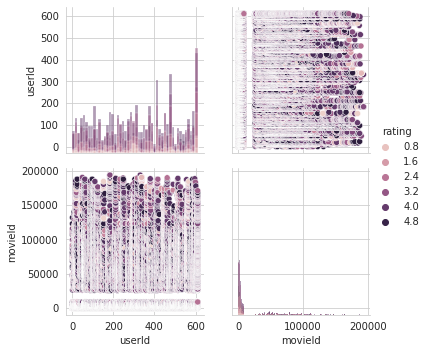

In [198]:
plt.figure(figsize=(25,15))
sns.set_style(style="whitegrid")

g = sns.PairGrid(rating_movie, hue="rating")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Preprocessing

In [199]:
def preprocess(df):
  df=df.copy()
  df.dropna(inplace=True)
  df.reset_index(drop=True,inplace=True)
  df.drop(index=df[df["rating"]==0].index,inplace=True)
  df["title"]=df["title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
  print(df.head())

In [200]:
preprocess(rating_movie)

   userId  movieId  rating  timestamp                    title  \
0       1        1     4.0  964982703           Toy Story 1995   
1       1        3     4.0  964981247    Grumpier Old Men 1995   
2       1        6     4.0  964982224                Heat 1995   
3       1       47     5.0  964983815   Seven a k a Se7en 1995   
4       1       50     5.0  964982931  Usual Suspects The 1995   

                                        genres movie_year  
0  Adventure|Animation|Children|Comedy|Fantasy       1995  
1                               Comedy|Romance       1995  
2                        Action|Crime|Thriller       1995  
3                             Mystery|Thriller       1995  
4                       Crime|Mystery|Thriller       1995  


## ITEM-BASED COLLABORATIVE FILTERING

In [201]:

def item_based(movie):
    movie=str(movie)
    
    if movie in df["title"].values:
        rating_count=pd.DataFrame(df["title"].value_counts())
        rare_books=rating_count[rating_count["title"]<=200].index
        common_books=df[~df["title"].isin(rare_books)]
        
        if movie in rare_books:
            most_common=pd.Series(common_books["title"].unique()).sample(3).values
            print("No Recommendations for this Movie \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books_pivot=common_books.pivot_table(index=["user-id"],columns=["title"],values="Book-Rating")
            title=common_books_pivot[movie]
            recommendation_df=pd.DataFrame(common_books_pivot.corrwith(title).sort_values(ascending=False)).reset_index(drop=False)
            
            if movie in [title for title in recommendation_df["title"]]:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["title"]==movie].index[0])
                
            less_rating=[]
            for i in recommendation_df["title"]:
                if df[df["title"]==i]["rating"].mean() < 5:
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df=recommendation_df[~recommendation_df["title"].isin(less_rating)]
                
            recommendation_df=recommendation_df[0:5]
            recommendation_df.columns=["title","Correlation"]
            
            fig, ax = plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("Would you try these  movies?",fontsize=40,color="deepskyblue")
            for i in range(len(recommendation_df["title"].tolist())):
                url=df.loc[df["title"]==recommendation_df["title"].tolist()[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {} ".format(round(df[df["title"]==recommendation_df["title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()
    else:
        print("❌ This movie not found ❌")

In [202]:
item_based("Toy Story 1995")

❌ This movie not found ❌


## CONTENT-BASED COLLABORATIVE FILTERING

In [203]:

def content_based(movie):
    movie=str(movie)
    
    if movie in df["title"].values:
        rating_count=pd.DataFrame(df["title"].value_counts())
        rare_books=rating_count[rating_count["title"]<=200].index
        common_books=df[~df["title"].isin(rare_books)]
        
        if movie in rare_books:
            most_common=pd.Series(common_books["title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books=common_books.drop_duplicates(subset=["title"])
            common_books.reset_index(inplace=True)
            common_books["index"]=[i for i in range(common_books.shape[0])]
            targets=["title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])
            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["title"]==movie]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            books=[]
            for i in range(len(similar_booksSorted)):
                
                books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["title"].item())
            fig,ax=plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="chocolate")
                
            for i in range(len(books)):
                
                url=common_books.loc[common_books["title"]==books[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {}".format(round(df[df["title"]==books[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()

    else:
        print("❌ COULD NOT FIND ❌")     

In [204]:
content_based("Story")

❌ COULD NOT FIND ❌
